In [18]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import mar
import preprocessing

In [ ]:
pat_num = 9

In [20]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

In [21]:
mar_data = preprocessing.load_mar_data(data_dir, pat_num)
sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
# sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
accel_data = preprocessing.load_accel_data(data_dir, pat_num)
# ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

In [22]:
mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

for mar_class in mar_classes:
    print(mar_class + " : " + str(mar_classes[mar_class].shape))

narcotics : (282, 4)
paralytics : (0, 4)
alpha_agonists : (332, 4)
ketamines : (7, 4)
propofols : (58, 4)
etomidates : (0, 4)
benzodiazepines : (80, 4)


In [23]:
drug_doses = {}
drug_concentrations = {}

for mar_class in mar_classes:
    if mar_classes[mar_class].shape[0] < 1:
        continue

    for drug_name in mar.classes()[mar_class]:
        drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
        
        if drug_df.shape[0] < 1:
            continue

        print(drug_name + " : " + str(drug_df.shape))

        drug_doses[drug_name] = mar.calculate_doses(drug_df)
        drug_concentrations[drug_name] = mar.calculate_concentrations_rk4(drug_doses[drug_name], elimination_rate=mar.elimination_rates()[drug_name])

print("")

for drug_name in drug_doses:
    print(drug_name + " : " + str(drug_doses[drug_name].shape))

fentanyl : (226, 4)
methadone : (56, 4)
dexmedetomidine : (315, 4)
clonidine : (17, 4)
ketamine : (7, 4)
propofol : (58, 4)
midazolam : (4, 4)
diazepam : (76, 4)

fentanyl : (10132, 4)
methadone : (28527, 4)
dexmedetomidine : (15186, 4)
clonidine : (29896, 4)
ketamine : (10166, 4)
propofol : (8939, 4)
midazolam : (10250, 4)
diazepam : (31677, 4)


In [24]:
metrics = {
    'heart_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'heart_rate': sickbay_data['heart_rate']
    }),
    'respiratory_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'respiratory_rate': sickbay_data['respiratory_rate']
    }),
    'acceleration': pd.DataFrame({
        'time': accel_data['time'],
        'acceleration': accel_data['a']
    }),}

In [25]:
start = max([df['time'].min() for df in metrics.values()])
stop = min([df['time'].max() for df in metrics.values()])

print(start)
print(stop)

2024-05-15 17:15:01
2024-05-20 18:44:26


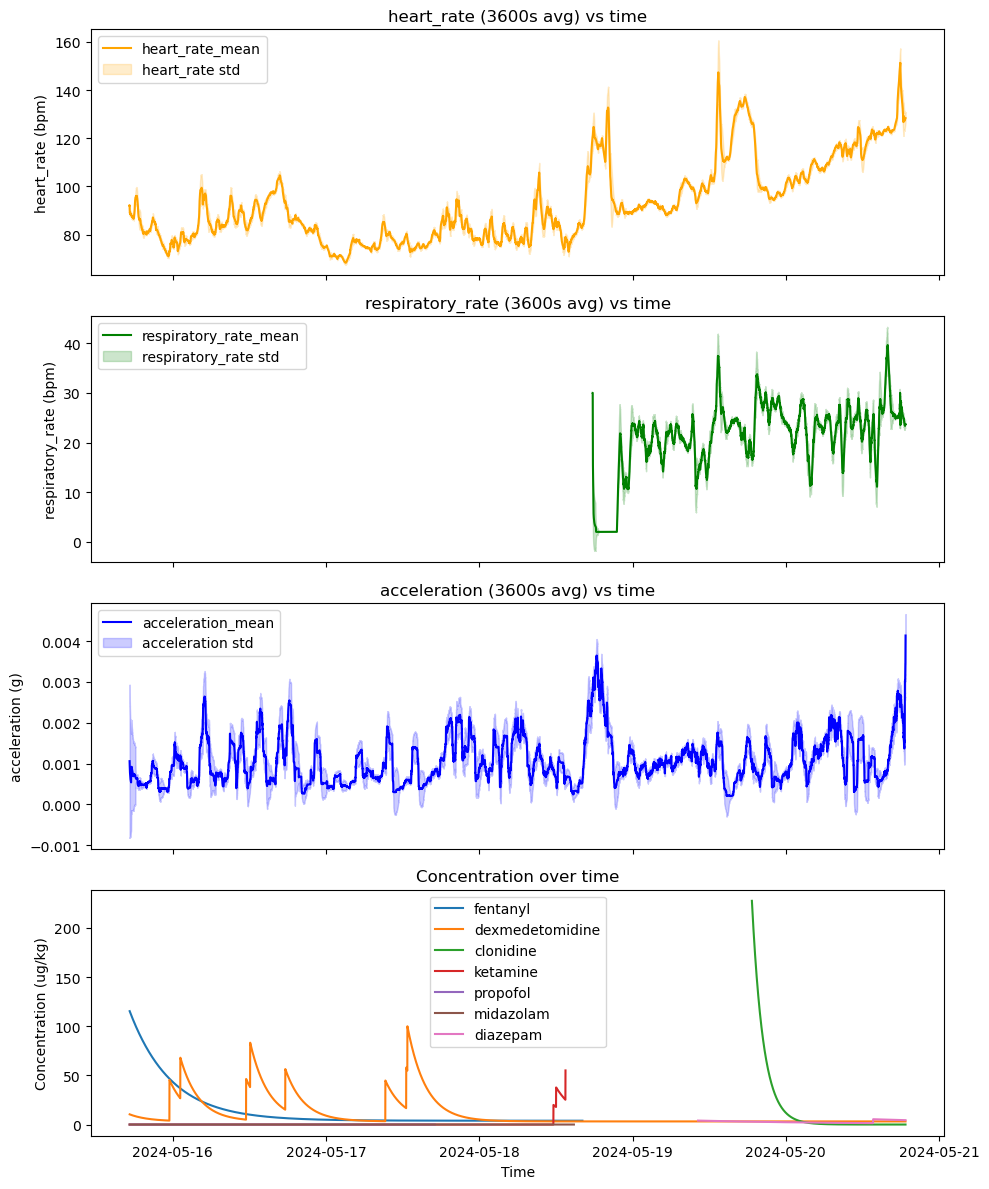

In [26]:
mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name='all', window=3600, std=True, start=start, stop=stop, show=True, save=None)

In [34]:
drug = 'dexmedetomidine'

In [35]:
drug_df = drug_doses[drug]
drug_df = drug_df[(drug_df['time'] >= pd.to_datetime(start)) & (drug_df['time'] <= pd.to_datetime(stop))].reset_index(drop=True)
drug_df = drug_df[drug_df['bolus_dose'] != 0].reset_index(drop=True)

print(drug_df)

                 time       dose  continuous_dose  bolus_dose
0 2024-05-15 23:30:00  41.518333         0.018333        41.5
1 2024-05-16 01:12:00  41.518333         0.018333        41.5
2 2024-05-16 11:30:00  41.518333         0.018333        41.5
3 2024-05-16 12:08:00  45.518333         0.018333        45.5
4 2024-05-16 17:38:00  41.518333         0.018333        41.5
5 2024-05-17 09:18:00  41.518333         0.018333        41.5
6 2024-05-17 12:34:00  41.518333         0.018333        41.5
7 2024-05-17 12:45:00  45.518333         0.018333        45.5


In [36]:
times, doses = [], []

hr_means_before = []
hr_vars_before = []
hr_means_after = []
hr_vars_after = []

rr_means_before = []
rr_vars_before = []
rr_means_after = []
rr_vars_after = []

a_means_before = []
a_vars_before = []
a_means_after = []
a_vars_after = []

for i in range(len(drug_df)):
    time = drug_df.iloc[i, 0]
    dose = drug_df.iloc[i, 3]

    hr = metrics['heart_rate']
    hr_before = hr[(hr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (hr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    hr_after = hr[(hr['time'] >= pd.to_datetime(time)) & (hr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)
    
    rr = metrics['respiratory_rate']
    rr_before = rr[(rr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (rr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    rr_after = rr[(rr['time'] >= pd.to_datetime(time)) & (rr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)

    a = metrics['acceleration']
    a_before = a[(a['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=30)) & (a['time'] <= pd.to_datetime(time))].reset_index(drop=True)
    a_after = a[(a['time'] >= pd.to_datetime(time)) & (a['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=30))].reset_index(drop=True)

    times.append(time)
    doses.append(dose)

    hr_means_before.append(np.mean(hr_before['heart_rate']))
    hr_vars_before.append(np.var(hr_before['heart_rate']))
    hr_means_after.append(np.mean(hr_after['heart_rate']))
    hr_vars_after.append(np.var(hr_after['heart_rate']))

    rr_means_before.append(np.mean(rr_before['respiratory_rate']))
    rr_vars_before.append(np.var(rr_before['respiratory_rate']))
    rr_means_after.append(np.mean(rr_after['respiratory_rate']))
    rr_vars_after.append(np.var(rr_after['respiratory_rate']))

    a_means_before.append(np.mean(a_before['acceleration']))
    a_vars_before.append(np.var(a_before['acceleration']))
    a_means_after.append(np.mean(a_after['acceleration']))
    a_vars_after.append(np.var(a_after['acceleration']))

df = pd.DataFrame({
    'time': times,
    'dose': doses,
    'hr_mean_before': hr_means_before,
    'hr_var_before': hr_vars_before,
    'hr_mean_after': hr_means_after,
    'hr_var_after': hr_vars_after,
    'rr_mean_before': rr_means_before,
    'rr_var_before': rr_vars_before,
    'rr_mean_after': rr_means_after,
    'rr_var_after': rr_vars_after,
    'a_mean_before': a_means_before,
    'a_var_before': a_vars_before,
    'a_mean_after': a_means_after,
    'a_var_after': a_vars_after,})

display(df)

,time,dose,hr_mean_before,hr_var_before,hr_mean_after,hr_var_after,rr_mean_before,rr_var_before,rr_mean_after,rr_var_after,a_mean_before,a_var_before,a_mean_after,a_var_after
0,2024-05-15 23:30:00,41.5,71.896560,0.374761,75.950958,1.878867,NaN,NaN,NaN,NaN,0.000396,9.658485e-09,0.000822,1.038035e-08
1,2024-05-16 01:12:00,41.5,74.995859,1.175729,80.430125,0.634043,NaN,NaN,NaN,NaN,0.001125,3.349783e-09,0.001025,4.740243e-09
2,2024-05-16 11:30:00,41.5,85.803041,6.502807,82.477627,0.611024,NaN,NaN,NaN,NaN,0.001033,7.913228e-08,0.000548,1.850879e-08
3,2024-05-16 12:08:00,45.5,83.217852,1.588062,87.512307,1.778416,NaN,NaN,NaN,NaN,0.000493,3.900236e-09,0.000827,8.067113e-09
4,2024-05-16 17:38:00,41.5,95.842538,4.499008,90.994260,3.674418,NaN,NaN,NaN,NaN,0.001268,3.681294e-08,0.001700,1.820149e-07
5,2024-05-17 09:18:00,41.5,84.494113,0.731919,80.230760,0.320139,NaN,NaN,NaN,NaN,0.000941,4.826218e-09,0.001581,1.398736e-07
6,2024-05-17 12:34:00,41.5,78.171755,1.344167,77.428573,3.636302,NaN,NaN,NaN,NaN,0.000521,2.908312e-09,0.000597,3.338275e-11
7,2024-05-17 12:45:00,45.5,79.229742,0.401480,75.061024,2.621635,NaN,NaN,NaN,NaN,0.000572,7.507024e-10,0.000579,6.431693e-10


In [37]:
print(drug)

delta = np.mean(df['hr_mean_after'] - df['hr_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['hr_mean_before'], df['hr_mean_after'], alternative='greater')

print(f"Change in heart rate mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['hr_var_after'] - df['hr_var_before'])
t_statistic, p_value = stats.ttest_rel(df['hr_var_before'], df['hr_var_after'], alternative='greater')

print(f"Change in heart rate variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['rr_mean_after'] - df['rr_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['rr_mean_before'], df['rr_mean_after'], alternative='greater')

print(f"Change in respiratory rate mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['rr_var_after'] - df['rr_var_before'])
t_statistic, p_value = stats.ttest_rel(df['rr_var_before'], df['rr_var_after'], alternative='greater')

print(f"Change in respiratory rate variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['a_mean_after'] - df['a_mean_before'])
t_statistic, p_value = stats.ttest_rel(df['a_mean_before'], df['a_mean_after'], alternative='greater')

print(f"Change in accelerometry mean: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

delta = np.mean(df['a_var_after'] - df['a_var_before'])
t_statistic, p_value = stats.ttest_rel(df['a_var_before'], df['a_var_after'], alternative='greater')

print(f"Change in accelerometry variance: {delta}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}\n")

dexmedetomidine
Change in heart rate mean: -0.4457282888656362
T-statistic: 0.2886918952463716
P-value: 0.3905894990570658

Change in heart rate variance: -0.1828858689084495
T-statistic: 0.19739542133104307
P-value: 0.4245638091123638

Change in respiratory rate mean: nan
T-statistic: nan
P-value: nan

Change in respiratory rate variance: nan
T-statistic: nan
P-value: nan

Change in accelerometry mean: 0.00016634975018861193
T-statistic: -1.2981197046234574
P-value: 0.8823109565880973

Change in accelerometry variance: 2.7865328863874087e-08
T-statistic: -1.086821315404261
P-value: 0.8434416162982091

